<a href="https://colab.research.google.com/github/dhguslee/Methods/blob/main/Gaussian_Process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Gaussian Process Regression**


[원본 사이트](http://krasserm.github.io/2018/03/19/gaussian-processes/)

---

### **Square Exponential Kernel**

$$k(x_i, x_j) = \sigma^2_f exp (- {1 \over 2 l^2} (x_i-x_j)^T(x_i-x_j))$$

In [ ]:
import numpy as np

### Squared exponential kernel

def se_kernel(X1, X2, l = 1.0, sigma_f = 1.0) :

    """
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        (m x n) matrix.
    """

    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)  # x^2 -2xy +y^2

    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

### **Prior - 사전분포**

$$prior \sim GP(0, k(x,x'))$$


$$\mu(x) = 0,　\\　k(x, x') = Square \ \  Exponential\ \  Kernel(l=1, \sigma^2_f=1)$$

Text(0.5, 1.0, 'Prior distribution (mu = 0)')

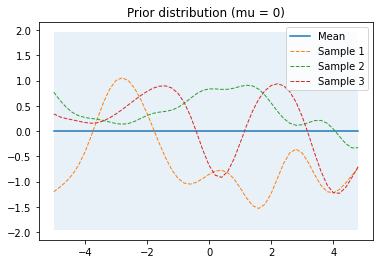

In [ ]:
def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[]):
    import matplotlib.pyplot as plt

    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
    
    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1)
    plt.plot(X, mu, label='Mean')
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label=f'Sample {i+1}')
    if X_train is not None:
        plt.plot(X_train, Y_train, 'rx')
    plt.legend()

#-------------------------------------------------------------------------------#

# Finite number of points
X = np.arange(-5, 5, 0.2).reshape(-1, 1)    # 50 X 1

# Mean and Covariance of the prior
mu = np.zeros(X.shape)                      # 50 X 1
cov = se_kernel(X, X)                       # 50 X 50

# Drow three samples from the prior
samples = np.random.multivariate_normal(mu.ravel(), cov, 3)   # mu = 0, cov = cov인 다변량# Mean and Covariance of the prior
mu = np.zeros(X.shape)                      # 50 X 1
cov = se_kernel(X, X)                       # 50 X 50

# Drow three samples from the prior
samples = np.random.multivariate_normal(mu.ravel(), cov, 3)   # mu = 0, cov = cov인 다변량 정규분포 3개 생성

# Plot GP mean, uncertainty region an samples
plot_gp(mu, cov, X, samples = samples)
plt.title("Prior distribution (mu = 0)")

### **Posterior (사후 분포)**

$$ y = f(x) + \varepsilon　　　\varepsilon \sim N(0, \sigma_y^2)$$
\
$$f(x) \sim GP(\ \mu(x) , k(x, x')\ ) 　　　\mu(x) = 0, k(x, x') = kernel$$

\

---
$$\left[ \begin{matrix} f \\ f_*\\  \end{matrix} \right] 
\sim 
N \left(0, \left( \begin{matrix} K & K_* \\ K_*^T & K_{**} \end{matrix} \right) \right)$$


\

$$(\ f_* : prediction 　X_* : New\ \ input\ )$$
\
$$p(f_* | X_*, X, y) = N(f_* | \mu_*, \sum{}_*)$$
\
　　　　　　　　　　　　　　　　　　　　　　　　　By  결합  정규분포를  조건화하는  공식


$$\mu_* = K^T_* K^{-1}_y y　　//　　\sum {}_* = K_{**} - K_*^TK_y^{-1}K_*$$

In [ ]:
from numpy.linalg import inv

def posterior(X_s, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=1e-8):
    """
    Args:
        X_s: New input locations (n x d).
        X_train: Training locations (m x d).
        Y_train: Training targets (m x 1).
        l: Kernel length parameter.
        sigma_f: Kernel vertical variation parameter.
        sigma_y: Noise parameter.
    
    Returns:
        Posterior mean vector (n x d) and covariance matrix (n x n).
    """
    K = se_kernel(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = se_kernel(X_train, X_s, l, sigma_f)
    K_ss = se_kernel(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    K_inv = inv(K)
    
    
    mu_s = K_s.T.dot(K_inv).dot(Y_train)

    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, cov_s

#### **Prediction from noisy training data**



Text(0.5, 1.0, 'Posterior distribution')

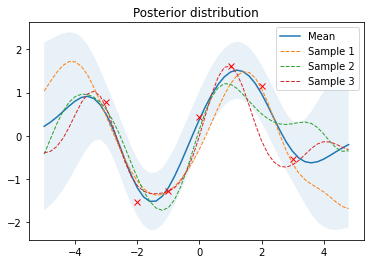

In [ ]:
noise = 0.4

# Noisy training data
X_train = np.arange(-3, 4, 1).reshape(-1, 1)      # 7 X 1
Y_train = np.sin(X_train) + noise * np.random.randn(*X_train.shape)


# Compute mean an covariance of the posterior distribution
mu_s, cov_s = posterior(X, X_train, Y_train, sigma_y = noise)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)

import matplotlib.pyplot as plt
plot_gp(mu_s, cov_s, X, X_train = X_train, Y_train = Y_train, samples = samples)
plt.title("Posterior distribution")

### **Effect of kernel parameters and nosie parameter**

\
- "$l$ and $ \sigma_f$"　are　kernel parameter

- "$\sigma_y$"　is　the noise parameter  (= $\varepsilon$)

\

$"l"$

- Higer $l$ : smoother function　therefore to coarser approximations of the training data

- Lower $l$ : wiggly function　　due to wide uncertainty regions between training data points

\

$"\sigma_f"$ : Controls the vertical variation of functions drawn from the GP.

- the wide uncertainty regions outside the training data region

\

$"\sigma_y"$ : the amount of noise in the training data.

- Higher $\sigma_y$ : It make more coarse approximations which avoids overfitting to noisy data.

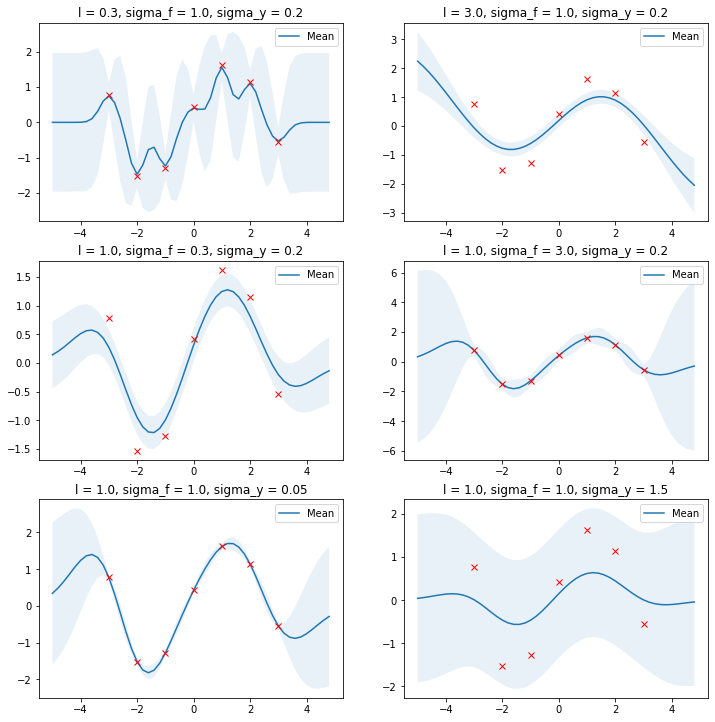

In [ ]:
import matplotlib.pyplot as plt

params = [
    (0.3, 1.0, 0.2),
    (3.0, 1.0, 0.2),
    (1.0, 0.3, 0.2),
    (1.0, 3.0, 0.2),
    (1.0, 1.0, 0.05),
    (1.0, 1.0, 1.5),
]

plt.figure(figsize=(12, 5))

for i, (l, sigma_f, sigma_y) in enumerate(params):
    mu_s, cov_s = posterior(X, X_train, Y_train, l=l, 
                            sigma_f=sigma_f, 
                            sigma_y=sigma_y)
    plt.subplot(3, 2, i + 1)
    plt.subplots_adjust(top=2)
    plt.title(f'l = {l}, sigma_f = {sigma_f}, sigma_y = {sigma_y}')
    plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train)